In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
def low(curr, p):
    global df
    return min(df['Low'][range(curr - p + 1, curr + 1)])

#print(low(df, df.index[-1], 9))

def high(curr, p):
    global df
    return max(df['High'][range(curr - p + 1, curr + 1)])

#print(high(df, df.index[-1], 9))

In [3]:
#don't touch df here
def sma(df, w):
    return df.iloc[:].rolling(window=w).mean()

In [4]:
def rsv(p):
    global df
    return [(df['Close'][df.index[curr]] - low(curr, p))/(high(curr, p) - low(curr, p)) for curr in range(p, len(df))]

def k(RSV, p):
    K = [0.5]
    for i in range(1, len(RSV)):
        K.append((2/3)*K[i-1] + (1/3)*RSV[i])
    return K

def d(K, q):
    D = [0.5]
    for i in range(1, len(K)):
        D.append((2/3)*D[i-1] + (1/3)*K[i])
    return D

def j(K, D, p):
    return [3*K[i] - 2*D[i] for i in range(len(K))]

def kdj(kp, dp, jp):
    global df
    RSV = rsv(kp)
    K = k(RSV, kp)
    D = d(K, dp)
    J = j(K, D, jp)
    return K, D, J

In [5]:
def fastStoc(curr, p):
    global df
    return (df['Close'][curr] - low(curr, p))/(high(curr, p) - low(curr, p))

def slowStoc(curr, p, q):
    global df
    fs = [fastStoc(i, p) for i in range(curr - p, curr + 1)]
    return sum(fs)/q, fs[-1]

def verySlowStoc(curr, p, q):
    global df
    fs = [fastStoc(i, p) for i in range(curr - p, curr + 1)]
    ss = [sum(fs[i - q:i + 1])/q for i in range(q, len(fs))]
    return sum(ss)/len(ss), ss[-1], fs[-1]

In [6]:
def tri(curr):
    global df
    return max((df['High'][curr] - df['Low'][curr]), 
               abs(df['High'][curr] - df['Close'][curr-1]),
               abs(df['Low'][curr] - df['Close'][curr-1]))

def trip(curr, p):
    return sum([tri(i) for i in range(curr - p + 1, curr + 1)])

def ptri(curr):
    global df
    div = max(df['High'][curr], df['Low'][curr], df['Close'][curr-1])
    return max((df['High'][curr] - df['Low'][curr])/div, 
               abs(df['High'][curr] - df['Close'][curr-1])/div,
               abs(df['Low'][curr] - df['Close'][curr-1])/div)

def ptrip(curr, p):
    return sum([ptri(i) for i in range(curr - p + 1, curr + 1)])

def atr(curr, p):
    return ptrip(curr, p)/p, ptri(curr)

def maatr(curr, p):
    ATR = pd.DataFrame([atr(i, p) for i in range(curr - p + 1, curr + 1)])
    SMA = sma(ATR, p)
    return SMA, ATR[ATR.index[-1]]

In [7]:
def upmove(curr):
    global df
    return df['High'][curr] - df['High'][curr - 1]

def downmove(curr):
    global df
    return df['Low'][curr - 1] - df['Low'][curr]

def dmplus(curr):
    return max(0, upmove(curr))

def dmminus(curr):
    return max(0, downmove(curr))

def dmpplus(curr, p):
    return sum([dmplus(i) for i in range(curr - p + 1, curr + 1)])

def dmpminus(curr, p):
    return sum([dmminus(i) for i in range(curr - p + 1, curr + 1)])

def diplus(curr, p):
    return dmpplus(curr, p)/trip(curr, p)

def diminus(curr, p):
    return dmpminus(curr, p)/trip(curr, p)

def dx(curr, p):
    dp = diplus(curr, p)
    dm = diminus(curr, p)
    dmdf = dp - dm
    dpdf = dp + dm
    DX = abs(dmdf)/dpdf
    return DX, dp, dm

# def adx(curr, p, q, DXl, dpl, dml):
#     global df
#     DXS, dp, dm = map(list, zip(*[dx(i, p) for i in range(curr - q + 1, curr + 1)]))
#     ADX = sum(DXS)/q
#     return ADX, dp[-1], dm[-1]

def dxprime(curr):
    global df
    global DXl
    global dpl
    global dml
    return 2*DXl[curr-1]-DXl[curr-2], 2*dpl[curr-1]-dpl[curr-2], 2*dml[curr-1]-dml[curr-2]

def dxpp(curr, p):
    global DXp
    global dpp
    global dmp
    DXpp = sum(DXp[curr - p + 1: curr + 1])/p
    dppp = sum(dpp[curr - p + 1: curr + 1])/p
    dmpp = sum(dmp[curr - p + 1: curr + 1])/p
    return DXpp, dppp, dmpp

def adx(curr, p, q):
    global df
    global DXl
    global dpl
    global dml
#     DXS, dp, dm = map(list, zip(*[dx(i, p) for i in range(curr - q + 1, curr + 1)]))
    ADX = sum(DXl[curr - q - p + 1: curr - p + 1])/q
    return ADX, dpl[curr-p], dml[curr-p]

def adx_plus(curr, p, q):
    dps = [diplus(i, p) for i in range(curr - q + 1, curr + 1)]
    dms = [diminus(i, p) for i in range(curr - q + 1, curr + 1)]
#     dp = dps[-1]
#     dm = dms[-1]
    dp = sum(dps)/q
    dm = sum(dms)/q
    dpa = dps[-1] - dps[-2]
    dma = dms[-1] - dms[-2]
    dmdf = pd.DataFrame([dp - dm])
    dpdf = pd.DataFrame([dp + dm])
    DX = abs(dmdf[0])/dpdf[0]
    return sum(DX)/len(DX), dp, dm, dpa, dma

In [8]:
def rs(curr, p):
    global df
    u = []
    d = []
    for i in range(curr - p + 1, curr + 1):
        if(df["Close"][i] > df["Open"][i]):
            u.append(df["Close"][i] - df["Open"][i])
        else:
            d.append(df["Open"][i] - df["Close"][i])
    avgup = sum(u)/p
    avgdown = sum(d)/p
    
    return avgup/avgdown

def rsi(curr, p):
    return 1 - (1/(1+rs(curr, p)))

In [9]:
#buy a certain amount BTC
#Now with TAXES YEAH
def buy_t(acc_usdt, acc_btc, price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= (buy_amount - buy_amount*0.001)*price
        acc_btc += buy_amount
    return acc_usdt, acc_btc

#sell a certain amount BTC
#Now with TAXES YEAH
def sell_t(acc_usdt, acc_btc, price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += (sell_amount - sell_amount*0.001)*price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc

In [10]:
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [11]:
def sell(price, weight):
    global acc_usdt
    global acc_btc
    
    out = "Trying to sell..."
    quantity = truncate(acc_btc*weight, 6)
    if quantity > 0.0001:
        acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, price, quantity)
        out = out + "Sold " + str(quantity) + "BTC at " + str(price)
        trade = True
        trade_type = "SELL"
    else:
        out = out + "Trade too small"
        trade = False
        trade_type = "NONE"
    return out, trade_type, trade

def buy(price, weight):
    global acc_usdt
    global acc_btc
    
    out = "Trying to buy..."
    quantity = truncate(((acc_usdt*weight)/price), 6)
    if quantity > 0.0001:
        acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, price, quantity)
        out = out + "Bought " + str(quantity) + "BTC at " + str(price)
        trade = True
        trade_type = "BUY"
    else:
        out = out + "Trade too small"
        trade = False
        trade_type = "NONE"
    return out, trade_type, trade


In [12]:
p = 39
q = 10

# p = 18
# q = 4

# for p in range(1, 73):
folder_path = 'data\\5y\\'
file_name = 'BTCUSDT-30m-from-2017-08-to-2021-08'
csv_path = file_name +'.csv'

# df = pd.read_csv(csv_path)

bdf = pd.read_csv(csv_path)

start = 0
end = len(bdf)
bdf = bdf.iloc[bdf.index[start:end]]
df = bdf

In [13]:
#Precalculate DX, dp, dm

p = 39
q = 10

print("Calculate DX...", end=" ")
t = time.time()
DXl, dpl, dml = map(list, zip(*[dx(curr, p) for curr in range(p, len(df))]))
pad = [0 for i in range(p)]
DXl = pad + DXl
dpl = pad + dpl
dml = pad + dml
print("Done in " + str(time.time() - t))

Calculate DX... Done in 224.1291310787201


In [14]:
#Precalculate dxprime

p = 39
q = 3

print("Calculate DXPrime...", end=" ")
t = time.time()
DXp, dpp, dmp = map(list, zip(*[dxprime(curr) for curr in range(p+1, len(df))]))
pad = [0 for i in range(p+1)]
DXp = pad + DXp
dpp = pad + dpp
dmp = pad + dmp
DXpp, dppp, dmpp = map(list, zip(*[dxpp(curr,q) for curr in range(p+q+1, len(df))]))
pad = [0 for i in range(p+q+1)]
DXpp = pad + DXpp
dppp = pad + dppp
dmpp = pad + dmpp
print("Done in " + str(time.time() - t))

Calculate DXPrime... Done in 0.4215579032897949


In [15]:
#Precalculate ADX

p = 39
q = 10

print("Calculate ADX...", end=" ")
t = time.time()
ADX, dp, dm = map(list, zip(*[adx(curr, p, q) for curr in range(p + q, len(df))]))
pad = [0 for i in range(p + q)]
ADX = pad + ADX
dp = pad + dp
dm = pad + dm
print("Done in " + str(time.time() - t))

Calculate ADX... Done in 0.19178414344787598


In [16]:
#Precalculate KDJ

p = 39
q = 10

print("Calculate KDJ...", end=" ")
t = time.time()
K, D, J = kdj(p, p, p)
pad = [0 for i in range(p)]
K = pad + K
D = pad + D
J = pad + J
print("Done in " + str(time.time() - t))

Calculate KDJ... Done in 42.2759051322937


In [17]:
#Precalculate Stochastic oscilator

p = 39
q = 10

print("Calculate Stochastic...", end=" ")
t = time.time()
# sss, ss, fs = map(list, zip(*[verySlowStoc(curr, p, q) for curr in range(2*p + q, len(df))]))
# pad = [0 for i in range(2*p + q)]
pad = [0 for i in range(len(df))]
sss = []
ss = []
fs = []
sss = pad + sss
ss = pad + ss
fs = pad + fs
print("Done in " + str(time.time() - t))

Calculate Stochastic... Done in 0.0032186508178710938


In [18]:
#Precalculate ATR

p = 39
q = 10

print("Calculate ATR...", end=" ")
t = time.time()
ATR, TR = map(list, zip(*[atr(curr, p) for curr in range(p, len(df))]))
pad = [0 for i in range(p)]
ATR = pad + ATR
TR = pad + TR
print("Done in " + str(time.time() - t))

Calculate ATR... Done in 129.81870865821838


In [19]:
#Precalculate RSI

p = 39
q = 10

print("Calculate RSI...", end=" ")
t = time.time()
RSI = [rsi(curr, p) for curr in range(p, len(df))]
pad = [0 for i in range(p)]
RSI = pad + RSI
print("Done in " + str(time.time() - t))

Calculate RSI... Done in 52.79801821708679


In [20]:
def trader(curr, p, q, last_trade_price, last_trade_type):
    global bdf
    global df
    global acc_usdt, acc_btc
    
    global ADX, DXl, dpl, dml
    global DXp, dpp, dmp
    global K, D, J
    global sss, ss, fs
    global SMATR, ATR
    global RSI
    
    weight = 1
    
    price = bdf['Close'][curr]
    trade = True
    trade_type = "NONE"
    
    b = 0
    s = 0
    
#     if ADX[curr] > 0.25:
#         b += ADX[curr]
#         s += ADX[curr]
    
#     if dpl[curr] > dml[curr]:
#         b += dpl[curr]
#     else:
#         s += dml[curr]
    
#     if J[curr] > K[curr]:
#         b += 1
#     if J[curr] < K[curr]:
#         s += 1
    
#     if RSI[curr] < 0.5:
#         b += 1
#     else:
#         s += 1
    
    pdp = max(dpp[curr], dppp[curr])
    mdp = min(dpp[curr], dppp[curr])
    pdm = max(dmp[curr], dmpp[curr])
    mdm = min(dmp[curr], dmpp[curr])
    
    # BUY
    if(last_trade_type != 'BUY' and (mdp > pdm and abs(mdp - pdm) > 0.02)):
        out, trade_type, trade = buy(price, weight)
    # SELL
    if(last_trade_type != 'SELL' and (pdp < mdm and abs(pdp - mdm) > 0.02)):
        out, trade_type, trade = sell(price, weight)
    
    if(trade_type == "NONE"):
        out = "No trade"
        trade = False

    if trade:
        return price, trade_type
    else:
        return 0, last_trade_type

In [21]:
out_columns = ["Timestamp", "High", "Low", "Close", "Action", 
               "Account Value", "K", "D", "J", "TR", "ATR", "RSI", 
               "dp", "dm", "ADX", "DXp", "dpp", "dmp", "dppp", "dmpp",
               "StocFast", "StocSlow", "StocVSlow"]

acc_value_hist = []
prev_time = 0
last_trade_price = 0
last_trade_type = "BUY"
ret_price = 0
out_df = pd.DataFrame([], columns = out_columns)
temp2_df = pd.DataFrame([], columns = out_columns)
acc_usdt = 0
acc_btc = 1 

p = 39
q = 10

for i in range(len(bdf)):
    if i >= 2*p + q : 
        df = bdf.loc[range(start + i - p - q, start + i + 1), :]
        df = df.astype(float)
    
        try:
            ret_price, last_trade_type = trader(i, p, q, last_trade_price, last_trade_type)
        except IndexError:
            print(i)
    if ret_price != 0:
        last_trade_price = ret_price
        trade_type = last_trade_type
    else:
        trade_type = "NONE"

    price = bdf['Close'][bdf.index[i]]
    acc_value = acc_usdt + acc_btc*price
    
    temp_df = pd.DataFrame([[bdf['Open Time'][bdf.index[i]], bdf["High"][i], bdf["Low"][i], 
                             price, trade_type, acc_value, 
                             K[i], 
                             D[i], 
                             J[i],
                             TR[i], 
                             ATR[i], 
                             RSI[i],
                             dpl[i], 
                             dml[i], 
                             ADX[i],
                             DXp[i],
                             dpp[i],
                             dmp[i],
                             dppp[i],
                             dmpp[i],
                             fs[i], 
                             ss[i], 
                             sss[i]]],columns = out_columns)
    temp2_df = temp2_df.append(temp_df)

    if i%1000==0:
        print(str(start + i) + " " + str(price) + " " + str(acc_value))
#             print("-", end = "")
        out_df = out_df.append(temp2_df)
        temp2_df = pd.DataFrame([], columns = out_columns)

print("Writing to file")
out_df = out_df.append(temp2_df)
print(str(len(out_df)) + " entries")
out_df.to_csv("test.csv")
print("Final state : " + str(p) + " " + str(q) + " " + str(price) + " " + str(acc_value))

0 4261.45 4261.45
1000 4458.0 4849.000107048989
2000 4179.06 4862.21594402376
3000 5550.01 5831.547306179129
4000 7188.96 7156.302070600263
5000 10699.68 9649.631245000262
6000 17620.0 14107.888612137242
7000 13754.38 18410.278649633008
8000 10097.25 18880.47673053337
9000 10242.0 28596.22224583709
10000 7878.0 30162.331823532146
11000 6598.99 31102.335154307086
12000 8830.01 33314.263947990476
13000 8286.0 33276.89671726582
14000 7636.4 30229.2793992497
15000 6139.0 28757.300024864464
16000 7316.13 35423.25670602854
17000 6262.86 32354.82402288587
18000 6993.01 32339.165526256667
19000 6323.86 32053.730971691508
20000 6583.0 32168.977221779816
21000 6325.0 32097.39272418356
22000 4680.98 32494.235572844813
23000 3402.96 33762.35604965841
24000 3776.41 33855.79996318537
25000 3574.99 33579.731924553074
26000 3647.64 35054.733853820195
27000 3841.22 34738.04384262705
28000 3942.45 34755.4663827788
29000 5045.62 41599.52974951025
30000 5950.01 50708.43038269812
31000 8654.13 64169.753393

<IPython.core.display.Javascript object>


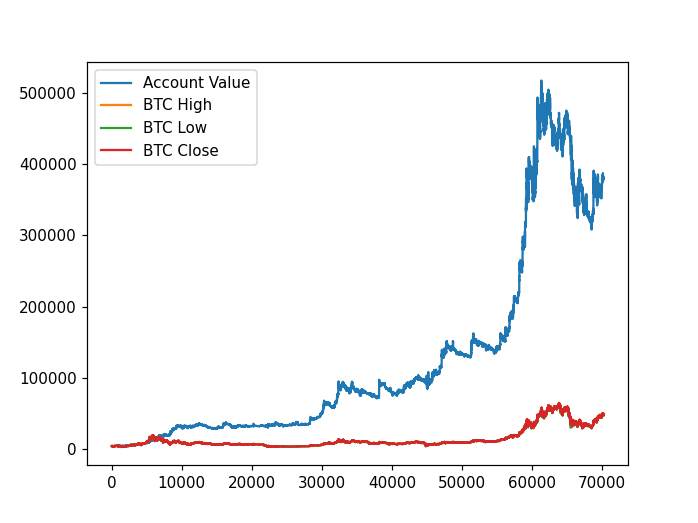

interactive(children=(FloatSlider(value=1.0, description='w', max=70284.0, min=1.0, step=500.0), Output()), _d…

<function __main__.update(w)>

In [27]:
%matplotlib notebook
from ipywidgets import *

# ["Timestamp", "High", "Low", "Close", "Action", 
#  "Account Value", "K", "D", "J", "ATR", "RSI", 
#  "dp", "dm", "ADX", "StocFast", "StocSlow", "StocVSlow"]

def update(w):
    x = 500
#     ax1.set_xlim(w, w + x)
    ax2.set_xlim(w, w + x)
    ax3.set_xlim(w, w + x)
    ax4.set_xlim(w, w + x)
    ax5.set_xlim(w, w + x)
    ax6.set_xlim(w, w + x)
    ax7.set_xlim(w, w + x)
    
csv_path = "test.csv"

df = pd.read_csv(csv_path)

ax1 = plt.subplot(1,1,1)
# ax1.set_yscale("log")
ax1.plot(df['Account Value'], label = "Account Value")
ax1.plot(df['High'], label = "BTC High")
ax1.plot(df['Low'], label = "BTC Low")
ax1.plot(df['Close'], label = "BTC Close")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax1.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax1.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax1.axvline(x=i, color="yellow", alpha=0.3)
plt.legend()

# ax2 = plt.subplot(7,1,2)
# ax2.plot(df['dp'], label = "d+")
# ax2.plot(df['dm'], label = "d-")
# ax2.plot(df['ADX'], label = "ADX")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax2.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax2.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax2.axvline(x=i, color="yellow", alpha=0.3)
# plt.legend()

# ax3 = plt.subplot(7,1,3)
# ax3.plot(df['K'], label = "K")
# ax3.plot(df['D'], label = "D")
# ax3.plot(df['J'], label = "J")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax3.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax3.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax3.axvline(x=i, color="yellow", alpha=0.3)
# plt.legend()

# ax4 = plt.subplot(7,1,4)
# ax4.plot(df['StocFast'], label = "StocFast")
# ax4.plot(df['StocSlow'], label = "StocSlow")
# ax4.plot(df['StocVSlow'], label = "StocVSlow")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax4.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax4.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax4.axvline(x=i, color="yellow", alpha=0.3)
# plt.legend()

# ax5 = plt.subplot(7,1,5)
# ax5.plot(df['TR'], label = "TR")
# ax5.plot(df['ATR'], label = "ATR")
# ax5.plot(2*df['ATR'], label = "2ATR")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax5.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax5.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax5.axvline(x=i, color="yellow", alpha=0.3)
# plt.legend()

# ax6 = plt.subplot(7,1,6)
# ax6.plot(df['RSI'], label = "RSI")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax6.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax6.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax6.axvline(x=i, color="yellow", alpha=0.3)
# plt.legend()

# ax7 = plt.subplot(7,1,7)
# # ax7.plot(df['DXp'], label = "DXp")
# ax7.plot(df['dppp'], label = "dppp")
# ax7.plot(df['dmpp'], label = "dmpp")
# ax7.plot(df['dpp'], label = "dpp")
# ax7.plot(df['dmp'], label = "dmp")
# for i, e in enumerate(df['Action']):
#     if e == "SELL":
#         ax7.axvline(x=i, color="red", alpha=0.3)
#     elif e == "BUY":
#         ax7.axvline(x=i, color="green", alpha=0.3)
#     elif e == "RESET":
#         ax7.axvline(x=i, color="yellow", alpha=0.3)
# plt.legend()

interact(update, w = widgets.FloatSlider(value=1, min=1, max=len(df), step=500))